In [5]:
import os, json, itertools, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import joblib
print("ALL MODULE ARE IMPORTED")

ALL MODULE ARE IMPORTED


In [6]:
df = pd.read_csv("data/raw/emotions_data.csv")
df.head()

,Unnamed: 0,Situation,emotion,empathetic_dialogues,labels,Unnamed: 5,Unnamed: 6
0,0,I remember going to the fireworks with my best...,sentimental,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju...",NaN,NaN
1,1,I remember going to the fireworks with my best...,sentimental,Customer :This was a best friend. I miss her.\...,Where has she gone?,NaN,NaN
2,2,I remember going to the fireworks with my best...,sentimental,Customer :We no longer talk.\nAgent :,Oh was this something that happened because of...,NaN,NaN
3,3,I remember going to the fireworks with my best...,sentimental,Customer :Was this a friend you were in love w...,This was a best friend. I miss her.,NaN,NaN
4,4,I remember going to the fireworks with my best...,sentimental,Customer :Where has she gone?\nAgent :,We no longer talk.,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64636 entries, 0 to 64635
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            64636 non-null  int64 
 1   Situation             64636 non-null  object
 2   emotion               64632 non-null  object
 3   empathetic_dialogues  64636 non-null  object
 4   labels                64636 non-null  object
 5   Unnamed: 5            113 non-null    object
 6   Unnamed: 6            5 non-null      object
dtypes: int64(1), object(6)
memory usage: 3.5+ MB


In [8]:
df['input_text'] = df['emotion'].astype(str) + " | " + df['empathetic_dialogues']
df.head(2)

,Unnamed: 0,Situation,emotion,empathetic_dialogues,labels,Unnamed: 5,Unnamed: 6,input_text
0,0,I remember going to the fireworks with my best...,sentimental,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju...",NaN,NaN,sentimental | Customer :I remember going to se...
1,1,I remember going to the fireworks with my best...,sentimental,Customer :This was a best friend. I miss her.\...,Where has she gone?,NaN,NaN,sentimental | Customer :This was a best friend...


In [9]:
def label_empathy(text):
    text = str(text).lower()

    high = [
        "sorry", "understand", "feel", "i’m here for you",
        "must be hard", "can imagine", "that’s tough", "help"
    ]
    supportive = ["glad", "appreciate", "thanks", "congrats", "good to hear", "happy"]
    low = ["ok", "hmm", "sure", "alright", "fine"]
    very_low = ["whatever", "your fault", "deal with it", "idc", "doesn’t matter"]

    for w in high:
        if w in text:
            return "high"
    for w in supportive:
        if w in text:
            return "supportive"
    for w in low:
        if w in text:
            return "low"
    for w in very_low:
        if w in text:
            return "very_low"
    return "neutral"

df['empathy_level'] = df['labels'].apply(label_empathy)
df['empathy_level'].value_counts()


empathy_level
neutral       50276
high           6482
low            4983
supportive     2814
very_low         81
Name: count, dtype: int64

In [10]:
#Data for training
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    df["input_text"].values,
    df["empathy_level"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["empathy_level"].values
)

vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english")
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec  = vectorizer.transform(X_test).toarray()

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)
y_train_oh = to_categorical(y_train)
y_test_oh  = to_categorical(y_test)

In [11]:
#Build and Train the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_vec.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train_vec, y_train_oh,
    epochs=7,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

C:\Users\Vishnu Nair\anaconda3\envs\empathy\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │       5,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,153,797 (19.66 MB)

 Trainable params: 5,153,797 (19.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
728/728 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - accuracy: 0.7773 - loss: 0.7856 - val_accuracy: 0.7797 - val_loss: 0.7373
Epoch 2/7
728/728 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.7817 - loss: 0.6580 - val_accuracy: 0.7805 - val_loss: 0.7809
Epoch 3/7
728/728 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.8034 - loss: 0.5309 - val_accuracy: 0.7639 - val_loss: 0.8819
Epoch 4/7
728/728 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.8565 - loss: 0.3872 - val_accuracy: 0.7130 - val_loss: 1.0933
Epoch 5/7
728/728 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.9123 - loss: 0.2528 - val_accuracy: 0.7090 - val_loss: 1.3301
Epoch 6/7
728/728 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9457 - loss: 0.1634 - val_accuracy: 0.7204 - val_loss: 1.6647
Epoch 7/7
728/728 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.9608 - loss: 0.1195 - val_accuracy: 0.6798 - val_loss: 1.7764


Test Accuracy: 0.6805
Macro F1: 0.23282556479926675

Classification report:
              precision    recall  f1-score   support

        high       0.18      0.16      0.17      1296
         low       0.11      0.07      0.09       997
     neutral       0.79      0.84      0.82     10056
  supportive       0.11      0.07      0.09       563
    very_low       0.00      0.00      0.00        16

    accuracy                           0.68     12928
   macro avg       0.24      0.23      0.23     12928
weighted avg       0.65      0.68      0.66     12928



C:\Users\Vishnu Nair\anaconda3\envs\empathy\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Vishnu Nair\anaconda3\envs\empathy\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Vishnu Nair\anaconda3\envs\empathy\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

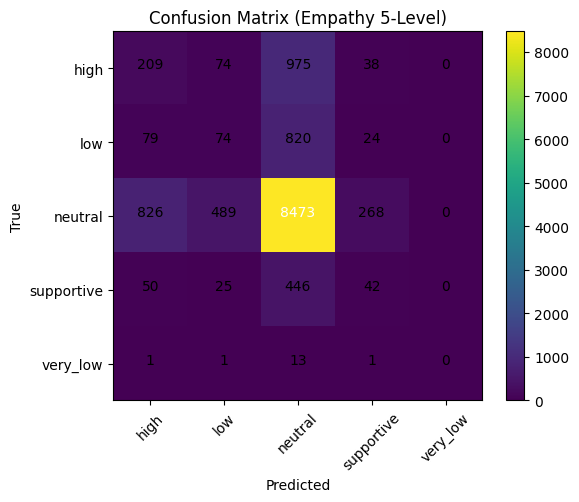

In [12]:
#evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import itertools

test_loss, test_acc = model.evaluate(X_test_vec, y_test_oh, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
y_pred_prob = model.predict(X_test_vec, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Empathy 5-Level)")
plt.colorbar()
ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=45)
plt.yticks(ticks, le.classes_)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [22]:
samples = [
    "Customer: I just lost my job. Agent: I’m so sorry to hear that, I know how stressful that must be.",
    "Customer: I won a competition! Agent: Congrats, that’s awesome!",
    "Customer: I feel like nobody cares. Agent: Well, that’s life.",
    "Customer: My dog passed away. Agent: Ok noted.",
    "Customer: My Wife is pragnant! I am Sad. Agent: I feel Bad"
]

X = vectorizer.transform(samples).toarray()
preds = le.inverse_transform(np.argmax(model.predict(X, verbose=0), axis=1))
for s, p in zip(samples, preds):
    print(f"{s}\n→ Predicted empathy level: {p}\n")


Customer: I just lost my job. Agent: I’m so sorry to hear that, I know how stressful that must be.
→ Predicted empathy level: high

Customer: I won a competition! Agent: Congrats, that’s awesome!
→ Predicted empathy level: neutral

Customer: I feel like nobody cares. Agent: Well, that’s life.
→ Predicted empathy level: neutral

Customer: My dog passed away. Agent: Ok noted.
→ Predicted empathy level: high

Customer: My Wife is pragnant! I am Sad. Agent: I feel Bad
→ Predicted empathy level: neutral

